В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle - шукайте посилання в уроці [Запрошення до участі у Kaggle-змаганні.](https://data-loves.kwiga.com/courses/machine-learning-dlia-liudei/domashnie-zavdannia-zmagannia-z-kaggle) Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
# !pip install opendatasets --upgrade --quiet

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from IPython.display import display
import pandas as pd
import numpy as np
import opendatasets as od
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import joblib
from sklearn.metrics import (
    confusion_matrix, 
roc_auc_score, 
roc_curve, f1_score, 
ConfusionMatrixDisplay, 
RocCurveDisplay,
accuracy_score
)

import warnings
warnings.filterwarnings("ignore")

In [3]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-3/data'
od.download(dataset_url)
data_dir = './bank-customer-churn-prediction-dlu-course-c-3'
raw_csv = data_dir + '/weatherAUS.csv'

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu-course-c-3" (use force=True to force download)


In [4]:
raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-3/train.csv')
test_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-3/test.csv')
sample_submission_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-3/sample_submission.csv')

In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [6]:
train_df, val_df = train_test_split(
    raw_df, test_size=0.2, 
    random_state=42, 
    stratify=raw_df['Exited'])

In [7]:
print(train_df.shape)
print(val_df.shape)

(12000, 14)
(3000, 14)


In [8]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (12000, 14)
val_df.shape : (3000, 14)
test_df.shape : (10000, 13)


In [9]:
test_df.to_csv('test_df.csv', index=False)
val_df.to_csv('val_df.csv', index=False)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [10]:
input_cols = list(train_df.columns)[1:-1]
exclude_cols = ['CustomerId', 'Surname']  
input_cols = [col for col in input_cols if col not in exclude_cols]
target_col = 'Exited'

train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [11]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

print(numeric_cols)
print(categorical_cols)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
['Geography', 'Gender']


4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [12]:
train_inputs[numeric_cols].describe().round(2)

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00
mean,658.84,37.69,5.03,43008.17,1.59,0.79,0.49,117992.40
std,72.33,8.14,2.78,59906.63,0.53,0.41,0.50,45589.48
min,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83343.73
50%,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123613.91
75%,708.00,42.00,7.00,109949.05,2.00,1.00,1.00,156912.81
max,850.00,74.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [13]:
train_inputs[categorical_cols].nunique()

Geography    3
Gender       2
dtype: int64

In [14]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ]), numeric_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]), categorical_cols)
])

train_inputs_transformed = preprocessor.fit_transform(train_inputs)
val_inputs_transformed = preprocessor.transform(val_inputs)

encoded_cat_cols = preprocessor.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)
all_transformed_cols = numeric_cols + list(encoded_cat_cols)

train_inputs_df = pd.DataFrame(train_inputs_transformed, columns=all_transformed_cols)
val_inputs_df = pd.DataFrame(val_inputs_transformed, columns=all_transformed_cols)

display(train_inputs_df.head())
display(val_inputs_df.head())

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.320187,-0.944682,-1.447264,1.475464,-1.108193,0.515062,1.016977,0.569450,1.0,0.0,0.0,0.0,1.0
1,0.347838,0.161227,-1.087792,2.254434,-1.108193,0.515062,-0.983306,0.603803,1.0,0.0,0.0,1.0,0.0
2,0.638166,-0.330288,0.350096,1.223831,0.769304,0.515062,-0.983306,1.238026,0.0,1.0,0.0,0.0,1.0
3,0.140460,2.495924,-1.806736,-0.717950,0.769304,-1.941514,1.016977,-1.457116,0.0,0.0,1.0,0.0,1.0
4,0.665816,-2.050591,-0.728320,-0.717950,0.769304,0.515062,1.016977,0.670629,1.0,0.0,0.0,0.0,1.0


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.762592,1.021379,-1.447264,1.214543,4.524299,0.515062,1.016977,-0.988144,0.0,1.0,0.0,0.0,1.0
1,-0.910252,0.406985,-0.009376,-0.717950,0.769304,0.515062,1.016977,-1.750392,1.0,0.0,0.0,0.0,1.0
2,0.997620,0.038348,-1.087792,-0.717950,0.769304,-1.941514,1.016977,-0.022404,1.0,0.0,0.0,1.0,0.0
3,0.195761,0.652742,-0.368848,1.881867,-1.108193,-1.941514,1.016977,-0.139723,1.0,0.0,0.0,1.0,0.0
4,0.264887,-0.944682,-0.368848,-0.717950,0.769304,0.515062,-0.983306,0.563519,0.0,0.0,1.0,1.0,0.0


5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [15]:
train_inputs_df.to_parquet(f'train_inputs.parquet', index=False)
train_targets.to_frame(name='Exited').to_parquet(f'train_targets.parquet', index=False)

val_inputs_df.to_parquet(f'val_inputs.parquet', index=False)
val_targets.to_frame(name='Exited').to_parquet(f'val_targets.parquet', index=False)

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [16]:
model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

model.fit(train_inputs, train_targets)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['CreditScore', 'Age',
                                                   'Tenure', 'Balance',
                                                   'NumOfProducts', 'HasCrCard',
                                                   'IsActiveMember',
                                                   'EstimatedSalary']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Geography', 'Gender'])])),
                ('classifier',
                 LogisticRegression(max_iter=1000, random_state=42))])

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?


Confusion Matrix (Train):


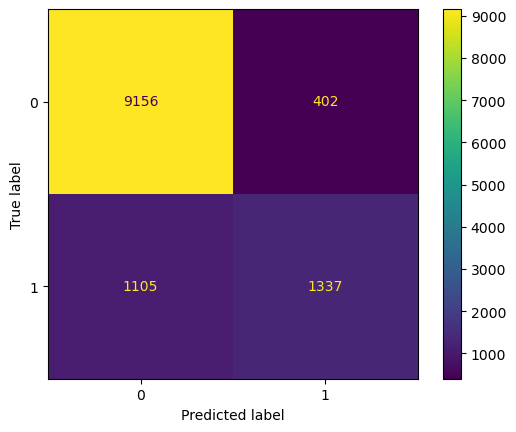

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


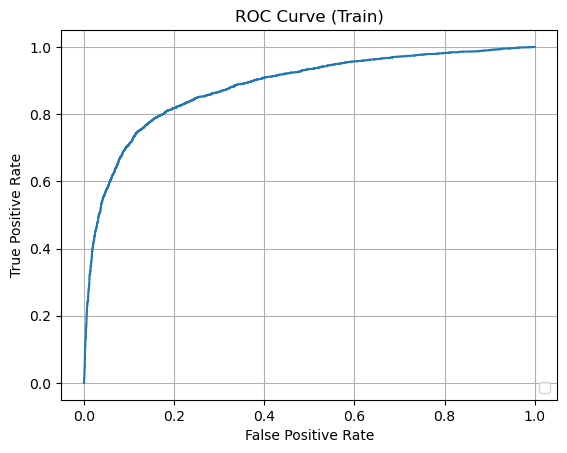

AUROC (Train): 0.8825
F1 Score (Train): 0.6396

Confusion Matrix (Validation):


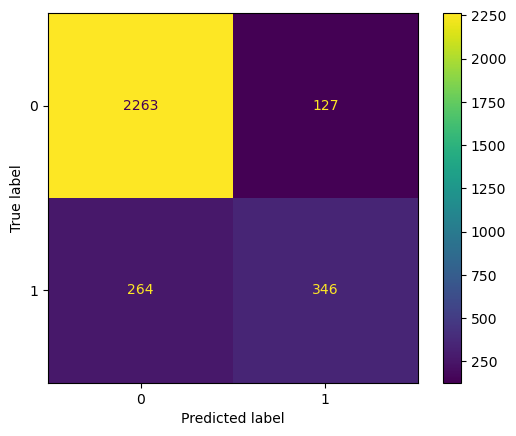

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


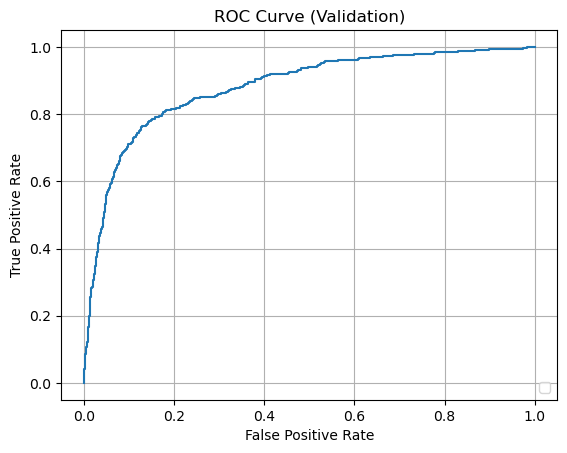

AUROC (Validation): 0.8797
F1 Score (Validation): 0.6390


In [17]:
def evaluate_model(model, X, y, dataset_name=''):
    probs = model.predict_proba(X)[:, 1]
    preds = (probs >= 0.5).astype(int)

    cm = confusion_matrix(y, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    print(f"\nConfusion Matrix ({dataset_name}):")
    disp.plot()
    plt.show()

    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y, probs)
    RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    plt.title(f'ROC Curve ({dataset_name})')
    plt.grid()
    plt.show()

    # Метрики
    auc_score = roc_auc_score(y, probs)
    f1 = f1_score(y, preds)
    print(f"AUROC ({dataset_name}): {auc_score:.4f}")
    print(f"F1 Score ({dataset_name}): {f1:.4f}")


evaluate_model(model, train_inputs, train_targets, dataset_name='Train')
evaluate_model(model, val_inputs, val_targets, dataset_name='Validation')

AUROC > 0.8 - дуже добре  
F1 Score при незбалансованих класах - хороший, якщо > 0.6

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [18]:
majority_class = train_targets.mode()[0]
print(f"Мажоритарний клас: {majority_class}")

train_preds_majority = [majority_class] * len(train_targets)
val_preds_majority = [majority_class] * len(val_targets)

acc_train_majority = accuracy_score(train_targets, train_preds_majority)
acc_val_majority = accuracy_score(val_targets, val_preds_majority)

train_preds_model = model.predict(train_inputs)
val_preds_model = model.predict(val_inputs)

acc_train_model = accuracy_score(train_targets, train_preds_model)
acc_val_model = accuracy_score(val_targets, val_preds_model)

print(f"Accuracy простої моделі (мажоритарний клас) на train: {acc_train_majority:.4f}")
print(f"Accuracy простої моделі (мажоритарний клас) на val:   {acc_val_majority:.4f}")

print(f"Accuracy навченої моделі на train: {acc_train_model:.4f}")
print(f"Accuracy навченої моделі на val:   {acc_val_model:.4f}")

Мажоритарний клас: 0.0
Accuracy простої моделі (мажоритарний клас) на train: 0.7965
Accuracy простої моделі (мажоритарний клас) на val:   0.7967
Accuracy навченої моделі на train: 0.8744
Accuracy навченої моделі на val:   0.8697


**Висновок**
Наша модель краще за просту модель мажоритарного класу - якість хороша.

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [19]:
joblib.dump(model, 'log_reg.joblib')

model_2 = joblib.load('log_reg.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [20]:
# import warnings
# warnings.filterwarnings("ignore")

# def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
#     input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
#     input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
#     X_input = input_df[numeric_cols + encoded_cols]
#     prob = model.predict_proba(X_input)[:,1]
#     return prob

# predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

In [21]:
def predict_raw_df(preprocessor, model, input_df: pd.DataFrame):
    X_processed = preprocessor.transform(input_df)
    prob = model.named_steps['classifier'].predict_proba(X_processed)[:, 1]
    return prob

predict_raw_df(preprocessor, model, raw_df[:5])

array([0.00562517, 0.03326039, 0.38086049, 0.3802367 , 0.97926323])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [22]:
test_raw_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-3/test.csv')
test_raw_df['Exited'] = predict_raw_df(preprocessor, model, test_raw_df)

test_raw_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86,0.069276
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28,0.033266
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45,0.153499
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87,0.198881
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97,0.054155


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [23]:
submission_df = pd.read_csv('./bank-customer-churn-prediction-dlu-course-c-3/sample_submission.csv')
test_preds = predict_raw_df(preprocessor, model, test_raw_df)
submission_df['Exited'] = test_preds

display(submission_df.head())

submission_df.to_csv('submission_log_reg.csv', index=False)

,id,Exited
0,15000,0.069276
1,15001,0.033266
2,15002,0.153499
3,15003,0.198881
4,15004,0.054155
